In [2]:
!pip install --upgrade pip
!pip install lightgbm

    100% |████████████████████████████████| 1.5MB 69.8MB/s ta 0:00:01
  Found existing installation: pip 9.0.1
    Uninstalling pip-9.0.1:
      Successfully uninstalled pip-9.0.1
Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 1.2 MB 3.3 MB/s eta 0:00:010 kB 3.3 MB/s eta 0:00:01


train_num:569385	test_num:4939
train_null:0	test_null:0
features:76
features:['longitude', 'latitude', 'speed', 'direction', 'start_port', 'end_port', 'start_lon', 'start_lat', 'end_lon', 'end_lat', 'geo_bin', 'speed_bin', 'direction_bin', 'end_geo_bin', 'lon_diff', 'lat_diff', 'lon_diff_bin', 'lat_diff_bin', 'lon_diff_start', 'lat_diff_start', 'lon_diff_start_bin', 'lat_diff_start_bin', 'dis_diff_start', 'dis_diff_start_bin', 'lon_diff_end', 'lat_diff_end', 'lon_diff_end_bin', 'lat_diff_end_bin', 'dis_diff_end', 'dis_diff_end_bin', 'start_year', 'start_month', 'start_weekofyear', 'start_dayofweek', 'start_hour', 'is_covids', 'trace_Dir_mean', 'trace_Dir_max', 'trace_Dir_min', 'trace_Dir_median', 'trace_Dir_std', 'trace_aver_speed_mean', 'trace_aver_speed_max', 'trace_aver_speed_min', 'trace_aver_speed_median', 'trace_aver_speed_std', 'trace_dis_mean', 'trace_dis_max', 'trace_dis_min', 'trace_dis_median', 'trace_dis_std', 'trace_start_anchor_time_mean', 'trace_start_anchor_time_max', '

[2900]	valid_0's l2: 52.1995
[2950]	valid_0's l2: 51.5474
[3000]	valid_0's l2: 50.7433
[3050]	valid_0's l2: 49.8968
[3100]	valid_0's l2: 49.1534
[3150]	valid_0's l2: 48.4233
[3200]	valid_0's l2: 47.9663
[3250]	valid_0's l2: 47.3384
[3300]	valid_0's l2: 46.8107
[3350]	valid_0's l2: 45.9661
[3400]	valid_0's l2: 45.3872
[3450]	valid_0's l2: 44.9273
[3500]	valid_0's l2: 44.3316
[3550]	valid_0's l2: 43.8926
[3600]	valid_0's l2: 43.3601
[3650]	valid_0's l2: 42.8624
[3700]	valid_0's l2: 42.2273
[3750]	valid_0's l2: 41.8461
[3800]	valid_0's l2: 41.4079
[3850]	valid_0's l2: 40.9563
[3900]	valid_0's l2: 40.5172
[3950]	valid_0's l2: 40.0978
[4000]	valid_0's l2: 39.8209
Did not meet early stopping. Best iteration is:
[4000]	valid_0's l2: 39.8209
MSE:39.820944259483795
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 2626.8
[100]	valid_0's l2: 712.882
[150]	valid_0's l2: 499.072
[200]	valid_0's l2: 415.341
[250]	valid_0's l2: 369.01
[300]	valid_0's l2: 326.229
[350]	v

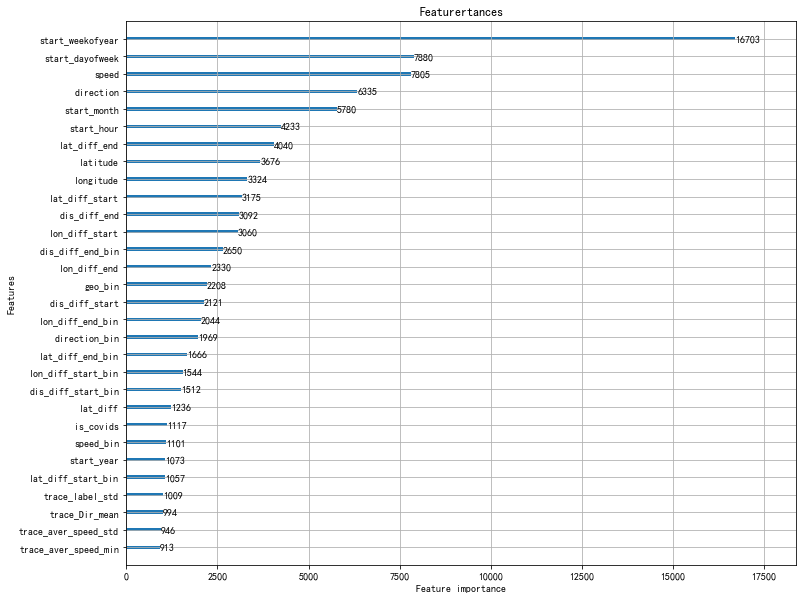

result
       loadingOrder       label
0    NJ169522947117   26.768235
1    SX540070026140   26.212781
2    ZV919459607351  121.189266
3    AE378244933121  181.975618
4    FQ684650477699  571.817285
5    WG447072368140  343.939030
6    ZB832047068480   24.348468
7    JU877708983002  187.822973
8    TI932873678567  310.898876
9    KX661536528233  478.012890
10   TL607029763227  455.530589
11   SF782540171392  391.690449
12   UJ905964781992  432.859092
13   EY867808907364   94.652481
14   YV342585220795  232.103857
15   BH596683987230   87.023173
16   YM142974602343  118.720225
17   DB915850020288  397.582326
18   CS451626121579   56.165337
19   DK806447229445  482.350450
20   OO873074032241   72.337997
21   HI185836900833  324.241772
22   NF648373052371   43.131482
23   VZ574268969534   27.842415
24   BW728719337627   98.990989
25   FT637253344444  484.484979
26   TG217980286566  514.632350
27   NR607703947338    8.690330
28   BD682197383786   73.226620
29   VR687514116673   96.784866
.

In [6]:
# 5折lgb模型
# 预处理：拼接trace统计特征（历史信息）
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgb
import time
import warnings
warnings.filterwarnings('ignore')

# -------------------------- 数据读取 ---------------------------------
# 训练集特征拼接
def train_feature_concate(df, trace_df):
    trace_df = trace_df.drop(['start_port', 'end_port'], axis = 1)
    df = df.merge(trace_df, on = ['TRANSPORT_TRACE'], how = 'left')
    
    return df


# 获取测试集路由在训练集中相同或相似路由
def get_match_trace(trace, start_port, end_port, trace_df):  
    # 匹配相同路由
    for i in range(len(trace_df)):
        if (trace == trace_df.loc[i, 'TRANSPORT_TRACE']):
            return trace_df.loc[i, 'TRANSPORT_TRACE']
    
    # 匹配相似路由
    for i in range(len(trace_df)):
        if (start_port == trace_df.loc[i, 'start_port']) and (end_port == trace_df.loc[i, 'end_port']):
            return trace_df.loc[i, 'TRANSPORT_TRACE']

# 测试集路由特征处理 
def test_trace_process(df, trace_df):
    trace_test = pd.DataFrame()  #测试集的路由统计信息
    
    trace_list = df.TRANSPORT_TRACE.unique()
    for i in range(len(trace_list)):
        trace = trace_list[i]
        test_trace_df = df[df['TRANSPORT_TRACE'] == trace].reset_index(drop = True)
        train_trace = get_match_trace(trace, test_trace_df.loc[0, 'start_port'], test_trace_df.loc[0, 'end_port'], trace_df)
        
        # 匹配 trace统计特征，并更改路由名称
        match_df = trace_df[trace_df['TRANSPORT_TRACE'] == train_trace].reset_index(drop = True)
        match_df['TRANSPORT_TRACE'] = trace
        
        trace_test = trace_test.append(match_df, ignore_index = True)
        
    trace_test = trace_test[trace_df.columns]
    return trace_test

# 测试集特征拼接
def test_feature_concate(df, trace_df):
    trace_df = test_trace_process(df, trace_df)
    
    trace_df = trace_df.drop(['start_port', 'end_port'], axis = 1)
    df = df.merge(trace_df, on = ['TRANSPORT_TRACE'], how = 'left')
    
    return df


def labelEncode(train_df, test_df):
    train_carrierName = train_df.carrierName.unique().tolist()
    train_vesselMMSI = train_df.vesselMMSI.unique().tolist()
    
    test_carrierName = test_df.carrierName.unique().tolist()
    test_vesselMMSI = test_df.vesselMMSI.unique().tolist()
    
    for i in range(len(test_carrierName)):
        if test_carrierName[i] not in train_carrierName:
            train_carrierName.append(test_carrierName[i])
            
    for i in range(len(test_vesselMMSI)):
        if test_vesselMMSI[i] not in train_vesselMMSI:
            train_vesselMMSI.append(test_vesselMMSI[i])
    
    le1 = LabelEncoder()
    le2 = LabelEncoder()
    le1.fit(train_carrierName)
    le2.fit(train_vesselMMSI)
    carrierLabel = le1.transform(train_carrierName)
    vesselLabel = le2.transform(train_vesselMMSI)
    
    carrier_df = pd.DataFrame({
        'carrierName': train_carrierName,
        'carrier_Num': carrierLabel 
    })
    vesselMMSI_df = pd.DataFrame({
        'vesselMMSI': train_vesselMMSI,
        'vessel_Num': vesselLabel
        
    })
    
    train_df = train_df.merge(carrier_df, on = 'carrierName', how = 'left')
    train_df = train_df.merge(vesselMMSI_df, on = 'vesselMMSI', how = 'left')
    
    test_df = test_df.merge(carrier_df, on = 'carrierName', how = 'left')
    test_df = test_df.merge(vesselMMSI_df, on = 'vesselMMSI', how = 'left')
    

    return train_df, test_df
    
# -------------------------- 模型训练 ---------------------------------
def build_model(train, test, feature, label, seed=1080, is_shuffle=True):
    train_pred = np.zeros((train.shape[0],))
    test_pred = np.zeros((test.shape[0],))
    n_splits = 5

    # Kfold
    fold = KFold(n_splits=n_splits, shuffle=is_shuffle, random_state=seed)
    kf_way = fold.split(train[feature])
    
    # params
    params = {
        'learning_rate': 0.03,
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'num_leaves': 30,
        'metric': 'mse',
        'reg_alpha': 0.03,
        'reg_lambda': 0.08,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.6,
        'bagging_freq': 6,
        'seed': 8,
        'bagging_seed': 1,
        'feature_fraction_seed': 7,
        'min_data_in_leaf': 30,
        'nthread': 8,
        'verbose': 1,
    }

    # train
    for n_fold, (train_idx, valid_idx) in enumerate(kf_way, start=1):
        train_x, train_y = train[feature].iloc[train_idx], train[label].iloc[train_idx]
        valid_x, valid_y = train[feature].iloc[valid_idx], train[label].iloc[valid_idx]

        # 数据加载
        n_train = lgb.Dataset(train_x, label=train_y)
        n_valid = lgb.Dataset(valid_x, label=valid_y)

        clf = lgb.train(
            params = params,
            train_set = n_train,
            num_boost_round = 4000,
            valid_sets = [n_valid],
            early_stopping_rounds = 50,
            verbose_eval = 50
        )
        train_pred[valid_idx] = clf.predict(valid_x, num_iteration = clf.best_iteration)

        MSE = mean_squared_error(train_pred[valid_idx], valid_y)
        print('MSE:{}'.format(MSE))

        test_pred += clf.predict(test[feature], num_iteration = clf.best_iteration) / fold.n_splits

    fig,ax = plt.subplots(figsize=(12, 10))
    lgb.plot_importance(clf, ax = ax, max_num_features = 30)
    plt.title("Featurertances")
    plt.show()

    test['travel_t'] = test_pred
    test['run_time'] = (pd.to_datetime(test['tmax']) - pd.to_datetime(test['timestamp'])).dt.total_seconds()/3600
    test['arr_time'] = test['travel_t'] - test['run_time']
    
    result = test.groupby(['loadingOrder'], sort = False)['arr_time'].agg({'label': np.mean}).reset_index()
  
    return test_pred, result

if __name__ == "__main__":
    start = time.process_time()
    
    # 训练集、测试集读取
    train_data =  pd.read_csv('../../../dataset/B_feature_gps/train_feature0809_02.csv')
    test_data =  pd.read_csv('../../../dataset/B_feature_gps/test_feature0809.csv')
    
    # 统计信息
    trace_df = pd.read_csv('../../../dataset/B_category_feature/trace_feature.csv')
    carrierName_df = pd.read_csv('../../../dataset/B_category_feature/carrierName_feature.csv')
#     vesselMMSI_df = pd.read_csv('../../../dataset/B_category_feature/vesselMMSI_feature.csv')
    start_port_df = pd.read_csv('../../../dataset/B_category_feature/start_port_feature.csv')
    end_port_df = pd.read_csv('../../../dataset/B_category_feature/end_port_feature.csv')


    # 特征拼接
    train = train_feature_concate(train_data, trace_df)
    test = test_feature_concate(test_data, trace_df)
    print('train_num:{}\ttest_num:{}'.format(len(train), len(test)))
    
    
    # 测试集、训练集Null值检查
    train_null = train[train.isnull().values == True]
    test_null = test[test.isnull().values == True]
    print('train_null:{}\ttest_null:{}'.format(len(train_null), len(test_null)))

    
#     train, test = labelEncode(train, test)
    features = [c for c in train.columns if c not in ['loadingOrder', 'timestamp', 'vesselMMSI', 'vessel_Num', 'carrierName',
                                                       'TRANSPORT_TRACE', 'trace_num', 'label', 'tmax']]
    
    print('features:{}'.format(len(features)))
    print('features:{}'.format(features))
    
    
    # 模型训练
    test_pred, result = build_model(train, test, features, 'label', is_shuffle=True)
    print('result\n%s'%(result))

    # 实验结果处理
    test_df = pd.read_csv('../../../dataset/test_data/B_testData0807.csv')
    test_df = test_df.drop_duplicates(['loadingOrder']).reset_index(drop = True)

    test_df = test_df.merge(result, on = 'loadingOrder', how = 'left')
    test_df = test_df[['loadingOrder', 'TRANSPORT_TRACE','onboardDate', 'label']]
    test_df.to_csv('../../../code result/B_label/label0809_02.csv', index=False)

    print('running time: {}'.format(time.process_time() - start))